In [27]:
import datetime as dt
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from pandas_ml import ConfusionMatrix

%matplotlib inline
import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot,plot
init_notebook_mode(connected=True)

In [4]:
conn = sqlite3.connect('../data/FPA_FOD_20170508.sqlite')
#c = conn.cursor()

In [5]:
df = pd.read_sql(""" SELECT * from Fires""",con=conn)

In [6]:
df.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

In [28]:
firedata = df.filter(['SOURCE_REPORTING_UNIT_NAME','STATE','LATITUDE','LONGITUDE','FIRE_SIZE_CLASS','FIRE_YEAR','DISCOVERY_DATE','STAT_CAUSE_DESCR','CONT_DATE'],axis=1)

firedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 9 columns):
SOURCE_REPORTING_UNIT_NAME    object
STATE                         object
LATITUDE                      float64
LONGITUDE                     float64
FIRE_SIZE_CLASS               object
FIRE_YEAR                     int64
DISCOVERY_DATE                float64
STAT_CAUSE_DESCR              object
CONT_DATE                     float64
dtypes: float64(4), int64(1), object(4)
memory usage: 129.1+ MB


In [16]:
print(firedata.head())

  SOURCE_REPORTING_UNIT_NAME STATE   LATITUDE   LONGITUDE FIRE_SIZE_CLASS  \
0     Plumas National Forest    CA  40.036944 -121.005833               A   
1   Eldorado National Forest    CA  38.933056 -120.404444               A   
2   Eldorado National Forest    CA  38.984167 -120.735556               A   
3   Eldorado National Forest    CA  38.559167 -119.913333               A   
4   Eldorado National Forest    CA  38.559167 -119.933056               A   

   FIRE_YEAR  DISCOVERY_DATE STAT_CAUSE_DESCR  CONT_DATE  
0       2005       2453403.5    Miscellaneous  2453403.5  
1       2004       2453137.5        Lightning  2453137.5  
2       2004       2453156.5   Debris Burning  2453156.5  
3       2004       2453184.5        Lightning  2453189.5  
4       2004       2453184.5        Lightning  2453189.5  


In [29]:
firedata['DISCOVERY_DATE'] = pd.to_datetime(firedata['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
firedata['DAY_OF_WEEK'] = pd.to_datetime(firedata['DISCOVERY_DATE']).dt.weekday_name
firedata['MONTH'] = pd.DatetimeIndex(firedata['DISCOVERY_DATE']).month
firedata['CONT_DATE'] = pd.to_datetime(firedata['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
firedata.head()

,SOURCE_REPORTING_UNIT_NAME,STATE,LATITUDE,LONGITUDE,FIRE_SIZE_CLASS,FIRE_YEAR,DISCOVERY_DATE,STAT_CAUSE_DESCR,CONT_DATE,DAY_OF_WEEK,MONTH
0,Plumas National Forest,CA,40.036944,-121.005833,A,2005,2005-02-02,Miscellaneous,2005-02-02,Wednesday,2
1,Eldorado National Forest,CA,38.933056,-120.404444,A,2004,2004-05-12,Lightning,2004-05-12,Wednesday,5
2,Eldorado National Forest,CA,38.984167,-120.735556,A,2004,2004-05-31,Debris Burning,2004-05-31,Monday,5
3,Eldorado National Forest,CA,38.559167,-119.913333,A,2004,2004-06-28,Lightning,2004-07-03,Monday,6
4,Eldorado National Forest,CA,38.559167,-119.933056,A,2004,2004-06-28,Lightning,2004-07-03,Monday,6


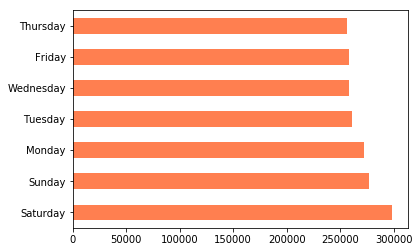

In [18]:
firedata['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

In [19]:
temp_df =firedata.groupby(['STAT_CAUSE_DESCR']).size().reset_index(name='count')

In [20]:
print(temp_df)

     STAT_CAUSE_DESCR   count
0               Arson  281455
1            Campfire   76139
2            Children   61167
3      Debris Burning  429028
4       Equipment Use  147612
5           Fireworks   11500
6           Lightning  278468
7       Miscellaneous  323805
8   Missing/Undefined  166723
9           Powerline   14448
10           Railroad   33455
11            Smoking   52869
12          Structure    3796


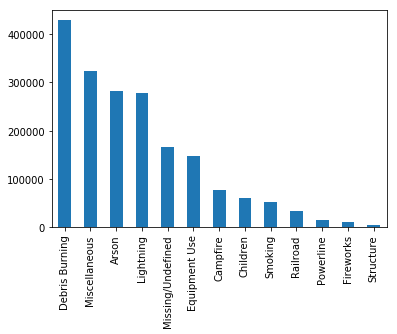

In [21]:
firedata['STAT_CAUSE_DESCR'].value_counts().plot(kind='bar')

In [30]:
V = firedata['STATE'].value_counts()

States = V.index.tolist()

data = dict(type='choropleth',
            #colorscale = 'Viridis',
            colorscale = 'Reds',
            reversescale = False,
            locations = States,
            z = V,
            locationmode = 'USA-states',
            text = States,
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 1)),
            colorbar = {'title':"Fires by State"}
            )
layout = dict(title = 'Wilds Fires by States',
              geo = dict(scope='usa',
                         showlakes = True,
                         lakecolor = 'rgb(85,173,240)')
             )
choromap = go.Figure(data = [data],layout = layout)

In [31]:
iplot(choromap)

In [32]:
from sklearn import preprocessing
enc = preprocessing.LabelEncoder()
firedata['STAT_CAUSE_DESCR'] = enc.fit_transform(firedata['STAT_CAUSE_DESCR'])
firedata['DAY_OF_WEEK'] = enc.fit_transform(firedata['DAY_OF_WEEK'])
firedata['MONTH'] = enc.fit_transform(firedata['MONTH'])
firedata['FIRE_SIZE_CLASS'] = enc.fit_transform(firedata['FIRE_SIZE_CLASS'])
firedata['STATE'] = enc.fit_transform(firedata['STATE'])
print(firedata.head())

  SOURCE_REPORTING_UNIT_NAME  STATE   LATITUDE   LONGITUDE  FIRE_SIZE_CLASS  \
0     Plumas National Forest      4  40.036944 -121.005833                0   
1   Eldorado National Forest      4  38.933056 -120.404444                0   
2   Eldorado National Forest      4  38.984167 -120.735556                0   
3   Eldorado National Forest      4  38.559167 -119.913333                0   
4   Eldorado National Forest      4  38.559167 -119.933056                0   

   FIRE_YEAR DISCOVERY_DATE  STAT_CAUSE_DESCR  CONT_DATE  DAY_OF_WEEK  MONTH  
0       2005     2005-02-02                 7 2005-02-02            6      1  
1       2004     2004-05-12                 6 2004-05-12            6      4  
2       2004     2004-05-31                 3 2004-05-31            1      4  
3       2004     2004-06-28                 6 2004-07-03            1      5  
4       2004     2004-06-28                 6 2004-07-03            1      5  


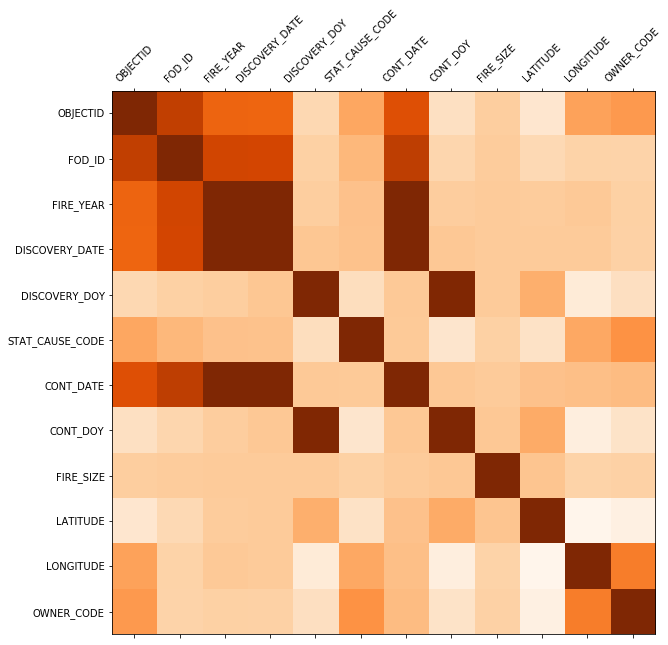

In [33]:
import matplotlib.pyplot as plt
def heat_map(df,size=10):
    corr = df.corr()  #the default method is pearson
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr,cmap=plt.cm.Oranges)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)    
    plt.show()
    

    
heat_map(df)

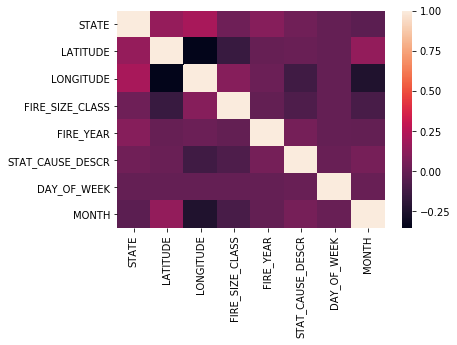

In [34]:
import seaborn as sns
corr =firedata.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)